## Classifying Cats vs Dogs using ConvNet

### 1. Data Importing and Pre-processing

In [1]:
# packages required for data import and preprocessing
import numpy as np
import os
from random import shuffle
from PIL import Image

In [2]:
# path to the datasets
TRAIN_PATH = './data/train'
TEST_PATH = './data/test'
IMG_SIZE = 64
LR = 1e-3
MODEL_NAME = 'cats_vs_dogs'
CHANNEL = 3


In [3]:
# utility functions

# Rescale the image to a fixed size
def rescale_img(img, new_size):
    return img.resize(new_size, Image.ANTIALIAS)

# label the image based on its file name
def label_image(img):
    # filename has label appended before the extension e.g cat.0.jpg
    file_name = img.split('.')[-3]
    if file_name == 'cat':
        return [1, 0]
    else:
        return [0, 1]
    
# process the training data
def process_train_dataset(path, size):
    training_data = []        
    for f in os.listdir(path):
        ext = os.path.splitext(f)[1]
        if ext.lower() not in ['.jpg']: continue
        img = Image.open(os.path.join(path, f))
        label = label_image(f)
        img = rescale_img(img, size)
        training_data.append([np.array(img), np.array(label)])
        img.close()
    shuffle(training_data)
    np.save('./data/train_data.npy', training_data)
    return training_data

# process the test data
def process_test_dataset(path, size):
    test_data = []        
    for f in os.listdir(path):
        ext = os.path.splitext(f)[1]
        if ext.lower() not in ['.jpg']: continue
        img = Image.open(os.path.join(path, f))
        img_num = f.split('.')[0]
        img = rescale_img(img, size)
        test_data.append([np.array(img), img_num])
        img.close()
    shuffle(test_data)
    np.save('./data/test_data.npy', test_data)
    return test_data

def load_training_data(path, size, channel = 3, overwrite = False):
    # load the training data as list that contains image
    # as a numpy array and it's corresponding label
    if os.path.exists('./data/train_data.npy') and overwrite == False:
        X = np.load('./data/train_data.npy')
    else:
        X = process_train_dataset(path, size)
    # split the dataset into test and validation sets
    X_orig_train = X[:-500]
    X_orig_dev = X[-500:]
    X_train = np.array([i[0] for i in X_orig_train]).reshape(-1, size[0], size[1], channel)
    Y_train = np.array([i[1] for i in X_orig_train])
    
    X_valid = np.array([i[0] for i in X_orig_dev]).reshape(-1, size[0], size[1], channel)
    Y_valid = np.array([i[1] for i in X_orig_dev])
    
    return X_train, Y_train, X_valid, Y_valid

def load_test_data(path, size, overwrite = False):
    if os.path.exists('./data/test_data.npy') and overwrite == False:
        test_data = np.load('./data/test_data.npy')
    else:
        test_data = process_test_dataset(path, size)
        
    return test_data



In [4]:
#X_orig = np.load('./data/train_data.npy')
#X_orig = load_dataset(TRAIN_PATH, (IMG_SIZE, IMG_SIZE))
#test_data = np.load('./data/test_data.npy')
test_data = load_test_data(TEST_PATH, (IMG_SIZE, IMG_SIZE), overwrite = True)
X_train, Y_train, X_valid, Y_valid = load_training_data(TRAIN_PATH, (IMG_SIZE, IMG_SIZE), CHANNEL, overwrite = False)
print(X_train.shape)
print(Y_train.shape)
print(X_valid.shape)
print(Y_valid.shape)

(24500, 64, 64, 3)
(24500, 2)
(500, 64, 64, 3)
(500, 2)


#### Split the dataset into training and validation (dev) sets


### 2. ConvNet via TensorFlow

In [11]:
import tensorflow as tf
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression
from tflearn.layers.normalization import local_response_normalization

In [12]:
tf.reset_default_graph()
convnet = input_data(shape = [None, IMG_SIZE, IMG_SIZE, 3], name = 'input')

convnet = conv_2d(convnet, 32, 5, activation = 'relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation = 'relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 128, 5, activation = 'relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation = 'relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 32, 5, activation = 'relu')
convnet = max_pool_2d(convnet, 5)

convnet = fully_connected(convnet, 1024, activation = 'relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation = 'softmax', weights_init = 'xavier')
convnet = regression(convnet, optimizer = 'adam', learning_rate = LR, loss = 'categorical_crossentropy', name = 'targets')

model = tflearn.DNN(convnet, tensorboard_dir = 'log')

model.fit({'input': X_train}, {'targets': Y_train}, n_epoch = 10, validation_set = ({'input': X_valid}, {'targets': Y_valid}),
         snapshot_step = 500, show_metric = True, run_id = MODEL_NAME, batch_size = 32)

Training Step: 7659  | total loss: 0.12035 | time: 223.852s
| Adam | epoch: 010 | loss: 0.12035 - acc: 0.9585 -- iter: 24480/24500
Training Step: 7660  | total loss: 0.11136 | time: 225.573s
| Adam | epoch: 010 | loss: 0.11136 - acc: 0.9627 | val_loss: 0.86122 - val_acc: 0.8060 -- iter: 24500/24500
--


### 3. Fine tuning pre-trained vgg16 model using Keras

In [5]:
from keras import Sequential
from keras.optimizers import SGD
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D, Dropout, Flatten, merge, Reshape, Activation
from keras.initializers import glorot_uniform
from keras.initializers import he_normal
from sklearn.metrics import log_loss

def vgg16_model(img_size, channel = 1, num_classes = None):
    model = Sequential()
    model.add(ZeroPadding2D((1, 1), input_shape=(img_size, img_size, channel)))
    model.add(Conv2D(64, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(64, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(128, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(128, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(256, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(256, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(512, 3, 3, activation='relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(512, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Add Fully Connected Layer
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1000, activation='softmax'))

    # Loads ImageNet pre-trained data
    model.load_weights('./models/vgg16_weights.h5', by_name = True)

    # Truncate and replace softmax layer for transfer learning
    model.layers.pop()
    model.outputs = [model.layers[-1].output]
    model.layers[-1].outbound_nodes = []
    model.add(Dense(num_classes, activation='softmax', kernel_initializer = he_normal(seed = 0)))

    # Uncomment below to set the first 10 layers to non-trainable (weights will not be updated)
    for layer in model.layers[:10]:
        layer.trainable = False

    # Learning rate is changed to 0.001
    sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model


/Users/ujjwal/.virtualenvs/cv/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [6]:
#X_train = X_train/255.
#X_valid = X_valid/255.
model = vgg16_model(IMG_SIZE, channel = 3, num_classes = 2)
#model.fit(X_train, Y_train,
#         batch_size = 16,
#         shuffle = True,
#         nb_epoch = 10,
#         verbose = 1,
#         validation_data = (X_valid, Y_valid),
#         )
#preds = model.evaluate(x = test_x, y = test_y)

#print()
#print ("Loss = " + str(preds[0]))
#print ("Test Accuracy = " + str(preds[1]))

/Users/ujjwal/.virtualenvs/cv/lib/python2.7/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`
  # This is added back by InteractiveShellApp.init_path()
/Users/ujjwal/.virtualenvs/cv/lib/python2.7/site-packages/ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`
  del sys.path[0]
/Users/ujjwal/.virtualenvs/cv/lib/python2.7/site-packages/ipykernel_launcher.py:17: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu")`
/Users/ujjwal/.virtualenvs/cv/lib/python2.7/site-packages/ipykernel_launcher.py:19: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu")`
/Users/ujjwal/.virtualenvs/cv/lib/python2.7/site-packages/ipykernel_launcher.py:23: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3, 3), activation="relu")`
/Users

### ResNet 50

In [ ]:


from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.initializers import glorot_uniform
from keras.utils import layer_utils
from keras.optimizers import SGD

#identity block
def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block as defined in Figure 3
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    ### START CODE HERE ###
    
    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1, 1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1, 1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)
    
    ### END CODE HERE ###
    
    return X

#convolutional block
def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    ### START CODE HERE ###

    # Second component of main path (≈3 lines)
    X = Conv2D(F2, (f, f), strides = (1, 1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(F3, (1, 1), strides = (1, 1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv2D(F3, (1, 1), strides = (s, s), padding = 'valid', name = conv_name_base + '1', kernel_initializer = glorot_uniform(seed = 0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    ### END CODE HERE ###
    
    return X

def ResNet50(input_shape = (64, 64, 3), classes = 2):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    ### START CODE HERE ###

    # Stage 3 (≈4 lines)
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4 (≈6 lines)
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5 (≈3 lines)
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X_FC = AveragePooling2D((2, 2))(X)
    
    ### END CODE HERE ###

    # output layer
    X_FC = Flatten()(X_FC)
    X_FC = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X_FC)
    
    
    # Create a new model if not using pretrained model
    model = Model(inputs = X_input, outputs = X_FC, name='ResNet50')

    # Load ImageNet pre-trained data
    model.load_weights('./models/resnet50_weights_tf_dim_ordering_tf_kernels.h5', by_name = True)    
    
    # Truncate and replace softmax layer for transfer learning
    # Cannot use model.layers.pop() since model is not of Sequential() type
    # The method below works since pre-trained weights are stored in layers but not in the model
    X_NEWFC = AveragePooling2D((2, 2), name='avg_pool')(X)
    X_NEWFC = Flatten()(X_NEWFC)
    X_NEWFC = Dense(classes, activation='softmax', name='fc10')(X_NEWFC)

    # Create another model with our customized softmax
    model = Model(X_input, X_NEWFC)

    # Learning rate is changed to 0.001
    sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])    
    


    # Truncate and replace softmax layer for transfer learning
    #model.layers.pop()
    #model.outputs = [model.layers[-1].output]
    #model.layers[-1].outbound_nodes = []
    #model.add(Dense(classes, activation='softmax', kernel_initializer = glorot_uniform(seed = 0)))

    # Uncomment below to set the first 10 layers to non-trainable (weights will not be updated)
    #for layer in model.layers[:10]:
    #    layer.trainable = False    

    return model

In [10]:
print(X_train.shape)
print(Y_train[9])

#X_test = np.array(test_data)
#a = [9, 1]
#print(a[0])
#print(test_data[0][0])

(24500, 64, 64, 3)
[1 0]


In [ ]:
model = ResNet50(input_shape = (IMG_SIZE, IMG_SIZE, CHANNEL), classes = 2)
model.fit(X_train, Y_train,
         batch_size = 32,
         shuffle = True,
         epochs = 10,
         verbose = 1,
         #validation_data = (X_valid, Y_valid),
         )

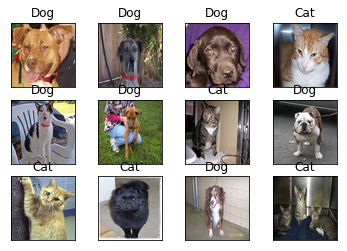

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline
import random
#test_data = np.load('./data/test_data.npy')
fig = plt.figure()
#random.shuffle(test_data)
for num, data in enumerate(test_data[:12]):
    img_num = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(3, 4, num + 1)
    orig = img_data
    data = img_data.reshape(IMG_SIZE, IMG_SIZE, 3)
    model_out = model.predict([data])[0]
    
    if np.argmax(model_out) == 1:
        str_label = 'Dog'
    else:
        str_label = 'Cat'
    y.imshow(orig)
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
    
plt.show()
    
        
        
    

In [16]:
with open('output\submission_file.csv','w') as f:
    f.write('id,label\n')
            
with open('output\submission_file.csv','a') as f:
    for data in (test_data):
        img_num = data[1]
        img_data = data[0]
        orig = img_data
        data = img_data.reshape(IMG_SIZE,IMG_SIZE,3)
        model_out = model.predict([data])[0]
        f.write('{},{}\n'.format(img_num,model_out[1]))

In [19]:
for data in test_data[:5]:
    img_num = data[1]
    img_data = data[0]
    data = img_data.reshape(IMG_SIZE,IMG_SIZE,3)
    print(model.predict([data]))
    print(model.predict([data]))[0][1]
    

[[0.12747271 0.87252724]]
0.87252724
[[0.00515224 0.9948478 ]]
0.9948478
[[8.4120152e-04 9.9915886e-01]]
0.99915886
[[1.000000e+00 1.742197e-08]]
1.742197e-08
[[0.00490236 0.9950976 ]]
0.9950976
